In [1]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f9ec68fbad0915d65f1b40d414917f9083feda5b734100425a5519eb78252652
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
import re
from rouge_score import rouge_scorer
import warnings

2025-07-23 15:34:49.049522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753284889.246147      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753284889.310673      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

# --- Configuration Section ---
FILE_PATH = '/kaggle/input/indo-article-data-summarization/IndoData200.csv'
MODELS_TO_COMPARE = [
    "cahya/t5-base-indonesian-summarization-cased",
    "gaduhhartawan/indobart-base"
]
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 64
TRAIN_BATCH_SIZE = 4
EVAL_BATCH_SIZE = 4
NUM_TRAIN_EPOCHS = 4
RANDOM_STATE = 42
# --- End of Configuration Section ---

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Data Loading & Preprocess

In [4]:
df = pd.read_csv(FILE_PATH)
df.head(5)

,article,summary
0,"Lukisan bunga Van Gogh terjual US$61,8 juta.\r...","Sebuah mahakarya Vincent van Gogh, yang diluki..."
1,Mengapa pengungsi Suriah diminta segera mening...,Ribuan pengungsi Suriah punya waktu hingga Sel...
2,Para pemain Chapecoense akan dikenang selamany...,"Ribuan orang berkumpul di kota Chapeco, Brasil..."
3,Kelompok Kurdi TAK klaim mengebom Ankara.\r\nD...,Kelompok militan Kurdi TAK mengatakan pihaknya...
4,Virus corona: Sejumlah dokter di India ‘diluda...,Sejumlah tenaga kesehatan di India dilaporkan ...


In [5]:
df.isnull()

,article,summary
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
195,False,False
196,False,False
197,False,False
198,False,False


In [6]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

print("Cleaning text...")
df['article'] = df['article'].apply(clean_text)
df['summary'] = df['summary'].apply(clean_text)

print(f"Dataset shape after cleaning: {df.shape}")

Cleaning text...
Dataset shape after cleaning: (200, 2)


# EDA

In [7]:
df['article_length'] = df['article'].str.split().str.len()
df['summary_length'] = df['summary'].str.split().str.len()

print("\nDescriptive Statistics for Text Lengths:")
print(df[['article_length', 'summary_length']].describe())


Descriptive Statistics for Text Lengths:
       article_length  summary_length
count       200.00000      200.000000
mean        358.13000       21.490000
std         228.75629        5.296239
min         116.00000       11.000000
25%         205.00000       18.000000
50%         277.50000       21.000000
75%         424.25000       24.250000
max        1379.00000       38.000000


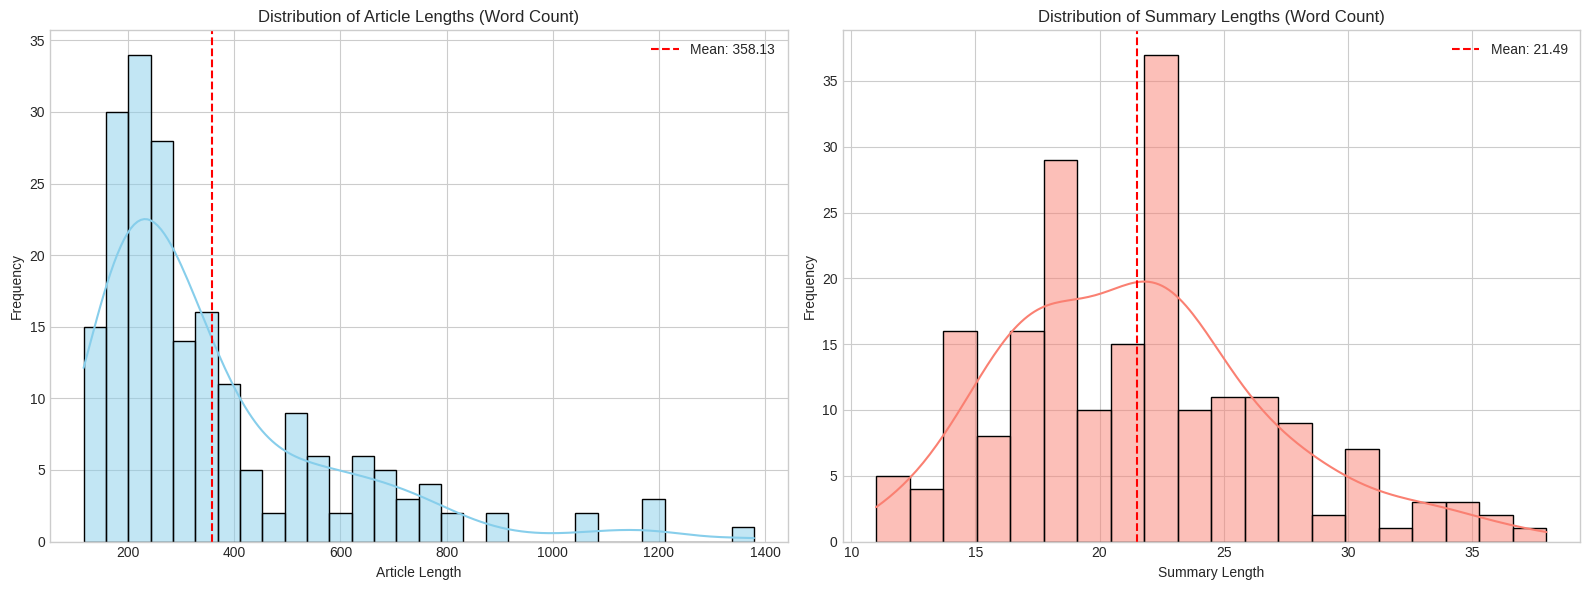

In [8]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['article_length'], bins=30, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Article Lengths (Word Count)')
axes[0].set_xlabel('Article Length')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['article_length'].mean(), color='r', linestyle='--', label=f"Mean: {df['article_length'].mean():.2f}")
axes[0].legend()

sns.histplot(df['summary_length'], bins=20, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Distribution of Summary Lengths (Word Count)')
axes[1].set_xlabel('Summary Length')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df['summary_length'].mean(), color='r', linestyle='--', label=f"Mean: {df['summary_length'].mean():.2f}")
axes[1].legend()

plt.tight_layout()
plt.show()


--- Word Cloud for Articles ---


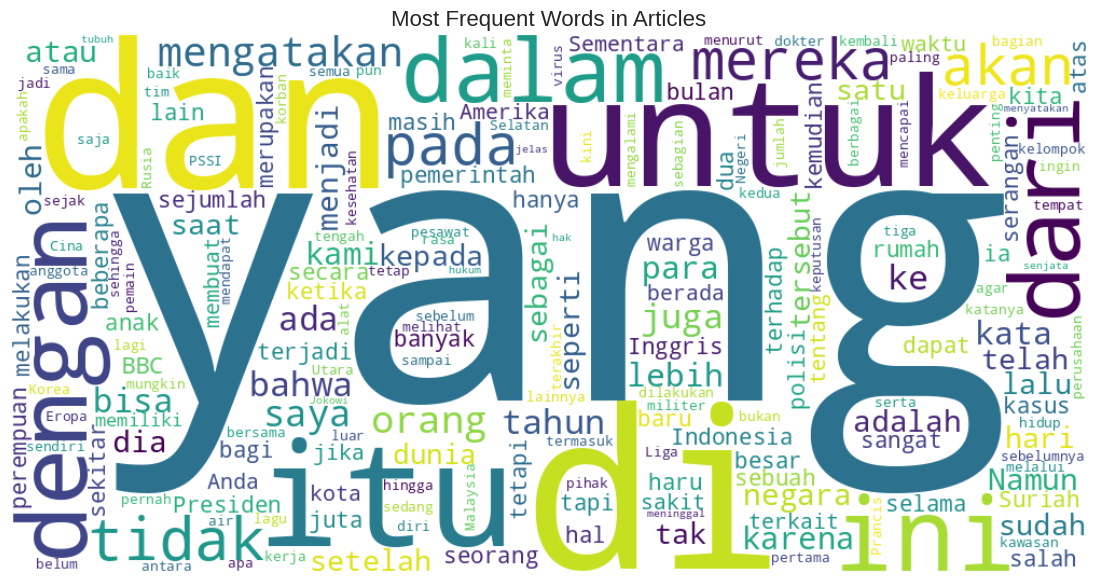


--- Word Cloud for Summaries ---


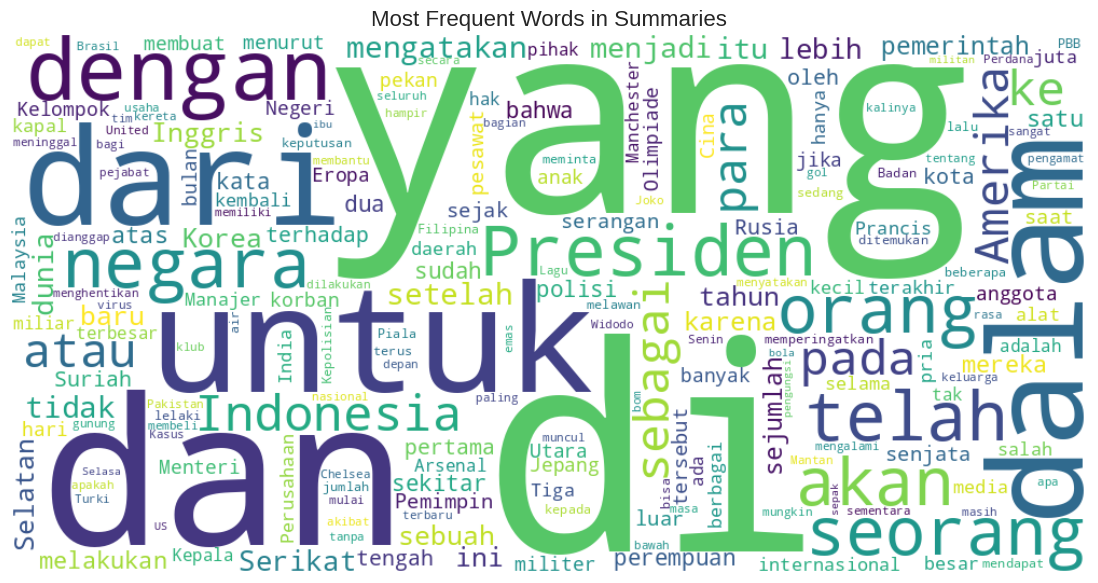

In [9]:
def generate_wordcloud(text, title):
    full_text = ' '.join(text.tolist())
    wordcloud = WordCloud(width=1000, height=500, background_color='white', collocations=False).generate(full_text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Word Cloud for Articles
print("\n--- Word Cloud for Articles ---")
generate_wordcloud(df['article'], 'Most Frequent Words in Articles')

# Word Cloud for Summaries
print("\n--- Word Cloud for Summaries ---")
generate_wordcloud(df['summary'], 'Most Frequent Words in Summaries')

In [10]:
df = df.drop(columns = ['article_length', 'summary_length'])

# Data Splitting

In [11]:
# Create train/validation/test splits
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_STATE)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Create HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df[['article', 'summary']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['article', 'summary']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['article', 'summary']].reset_index(drop=True))

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

Train set: 160 samples
Validation set: 20 samples
Test set: 20 samples


# Tokenization Function

In [12]:
def preprocess_function(examples, tokenizer, max_input_length, max_target_length):
    inputs = tokenizer(
        examples['article'],
        max_length=max_input_length,
        truncation=True,
        padding=False
    )

    with tokenizer.as_target_tokenizer():
        targets = tokenizer(
            examples['summary'],
            max_length=max_target_length,
            truncation=True,
            padding=False
        )

    inputs['labels'] = targets['input_ids']
    return inputs

# Compute Score Function

In [13]:
# ROUGE metrics computation
def compute_rouge_metrics(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

    for pred, ref in zip(predictions, references):
        pred = str(pred).strip() if pred else " "
        ref = str(ref).strip() if ref else " "
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    return {
        'rouge1': np.mean(rouge1_scores),
        'rouge2': np.mean(rouge2_scores),
        'rougeL': np.mean(rougeL_scores)
    }

# Compute metrics function for trainer
def compute_metrics(eval_preds, tokenizer):
    predictions, labels = eval_preds

    if isinstance(predictions, tuple):
        predictions = predictions[0]
    
    predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
    vocab_size = len(tokenizer)
    predictions = np.clip(predictions, 0, vocab_size - 1)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    
    rouge_metrics = compute_rouge_metrics(decoded_preds, decoded_labels)
    return rouge_metrics

# Training & Evaluation

In [14]:
def evaluate_model(model_name, dataset_dict, training_args):
    print(f"\n{'='*60}\nEvaluating Model: {model_name}\n{'='*60}")

    tokenizer = AutoTokenizer.from_pretrained(model_name, legacy=False)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    if model.config.vocab_size != len(tokenizer):
        print(f"Alert: Vocab size mismatch found for {model_name}.")
        print(f"  - Model config vocab size: {model.config.vocab_size}")
        print(f"  - Tokenizer vocab size:    {len(tokenizer)}")
        print("Resizing model token embeddings to match tokenizer.")
        model.resize_token_embeddings(len(tokenizer))
        
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.pad_token_id

    model.to(device)

    tokenized_datasets = dataset_dict.map(
        lambda examples: preprocess_function(examples, tokenizer, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH),
        batched=True,
        remove_columns=dataset_dict['train'].column_names
    )

    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True)

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=lambda eval_preds: compute_metrics(eval_preds, tokenizer),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)]
    )

    print("--- Starting training ---")
    trainer.train()

    print("\n--- Evaluating on test set ---")
    test_results = trainer.evaluate(eval_dataset=tokenized_datasets['test'], metric_key_prefix="test")

    print(f"\nFinal Test Results for {model_name}:")
    print(f"  ROUGE-1: {test_results['test_rouge1']:.4f}")
    print(f"  ROUGE-2: {test_results['test_rouge2']:.4f}")
    print(f"  ROUGE-L: {test_results['test_rougeL']:.4f}")

    print("\n--- Generating sample predictions ---")
    sample_data = dataset_dict['test'].select(range(3))
    sample_tokenized = tokenized_datasets['test'].select(range(3))

    predictions = trainer.predict(sample_tokenized)
    decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)

    print("\nSample Predictions:")
    for i, (article, reference, prediction) in enumerate(zip(
        sample_data['article'],
        sample_data['summary'],
        decoded_preds
    )):
        print(f"\nSample {i+1}:")
        print(f"| Article   |: {article[:150]}...")
        print(f"| Reference |: {reference}")
        print(f"| Prediction|: {prediction.strip()}")
        print("-" * 50)

    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return {
        'model_name': model_name,
        'rouge1': test_results['test_rouge1'],
        'rouge2': test_results['test_rouge2'],
        'rougeL': test_results['test_rougeL']
    }

# Run

In [15]:
results = []

In [16]:
for model_name in MODELS_TO_COMPARE:
    output_dir = f'./results_{model_name.replace("/", "_")}'
    logging_dir = f'./logs_{model_name.replace("/", "_")}'

    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        logging_dir=logging_dir,
        num_train_epochs=NUM_TRAIN_EPOCHS,
        per_device_train_batch_size=TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=EVAL_BATCH_SIZE,
        warmup_steps=0,
        weight_decay=0,
        logging_strategy="epoch",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="rougeL",
        greater_is_better=True,
        save_total_limit=1,
        predict_with_generate=True,
        generation_max_length=MAX_TARGET_LENGTH,
        generation_num_beams=2,
        fp16=torch.cuda.is_available(),
        report_to="none",
    )
    
    result = evaluate_model(model_name, dataset_dict, training_args)
    results.append(result)
    print(f"Successfully evaluated {model_name}")


Evaluating Model: cahya/t5-base-indonesian-summarization-cased


tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/793k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Alert: Vocab size mismatch found for cahya/t5-base-indonesian-summarization-cased.
  - Model config vocab size: 32128
  - Tokenizer vocab size:    32100
Resizing model token embeddings to match tokenizer.


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

--- Starting training ---


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,3.196700,2.792437,0.283260,0.094995,0.224729
2,2.745300,2.766848,0.268790,0.101092,0.220777
3,2.531500,2.761569,0.272015,0.095944,0.223648


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].



--- Evaluating on test set ---


early stopping required metric_for_best_model, but did not find eval_rougeL so early stopping is disabled



Final Test Results for cahya/t5-base-indonesian-summarization-cased:
  ROUGE-1: 0.2326
  ROUGE-2: 0.0833
  ROUGE-L: 0.1756

--- Generating sample predictions ---

Sample Predictions:

Sample 1:
| Article   |: Apa yang terjadi saat manusia sekarat?. Orang-orang sering mengira bahwa kehidupan adalah pertempuran melawan kematian. Tetapi apakah mungkin berdamai...
| Reference |: Sejumlah orang mengatakan saat sekarat seseorang akan merasa bahagia. Apa itu benar?
| Prediction|: Apa yang terjadi saat manusia sekarat ?. Orang-orang sering mengira bahwa kehidupan adalah pertempuran melawan kematian. Tetapi apakah mungkin berdamai dengan kematian ? Sebagai ahli perawatan paliatif, saya pikir proses kematian terjadi dua minggu sebelum kita meninggal.
--------------------------------------------------

Sample 2:
| Article   |: Tes darah rutin dapat deteksi kanker ovarium. Uji coba ini akan mengubah metode deteksi tes darah Hasil uji coba ini dapat mengubah metode pemeriksaan...
| Reference |: Te

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/356 [00:00<?, ?B/s]

Alert: Vocab size mismatch found for gaduhhartawan/indobart-base.
  - Model config vocab size: 50264
  - Tokenizer vocab size:    50265
Resizing model token embeddings to match tokenizer.


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

--- Starting training ---


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,2.171300,2.076177,0.242641,0.094029,0.203177
2,1.479900,2.143878,0.254710,0.089886,0.197604
3,1.043100,2.246586,0.273330,0.100539,0.218431
4,0.747000,2.457702,0.276305,0.106465,0.216410


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



--- Evaluating on test set ---


early stopping required metric_for_best_model, but did not find eval_rougeL so early stopping is disabled



Final Test Results for gaduhhartawan/indobart-base:
  ROUGE-1: 0.2525
  ROUGE-2: 0.0884
  ROUGE-L: 0.2121

--- Generating sample predictions ---

Sample Predictions:

Sample 1:
| Article   |: Apa yang terjadi saat manusia sekarat?. Orang-orang sering mengira bahwa kehidupan adalah pertempuran melawan kematian. Tetapi apakah mungkin berdamai...
| Reference |: Sejumlah orang mengatakan saat sekarat seseorang akan merasa bahagia. Apa itu benar?
| Prediction|: Orang-orang sering mengira bahwa kehidupan adalah pertempuran melawan kematian. Tetapi apakah mungkin juga ada peningkatan endorphin sebelum seseorang meninggal.
--------------------------------------------------

Sample 2:
| Article   |: Tes darah rutin dapat deteksi kanker ovarium. Uji coba ini akan mengubah metode deteksi tes darah Hasil uji coba ini dapat mengubah metode pemeriksaan...
| Reference |: Tes darah rutin dapat mendeteksi 86% kanker ovarium lebih awal sebelum masa dimana perempuan dapat didiagnosa memiliki sel kanker,

In [17]:
print(f"\n{'='*80}\nFINAL MODEL COMPARISON RESULTS\n{'='*80}")

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

best_model = results_df.loc[results_df['rougeL'].idxmax()]
print(f"\nBest performing model: {best_model['model_name']}")
print(f"Best ROUGE-L score: {best_model['rougeL']:.4f}")


FINAL MODEL COMPARISON RESULTS
                                  model_name   rouge1   rouge2   rougeL
cahya/t5-base-indonesian-summarization-cased 0.232551 0.083323 0.175556
                 gaduhhartawan/indobart-base 0.252479 0.088396 0.212145

Best performing model: gaduhhartawan/indobart-base
Best ROUGE-L score: 0.2121
